The Quality Score - Extracting 'Quality' From Your Pipeline

This notebook was created in an attempt to research a multitude of factors, and analyze their risk and returns against the pipeline. The notebook has a default lookback period of 252 days (average trading days per year) --this can be adjusted. Ultimately, we are trying to analyze the fundamental ratios that contribute to the highest 'quality' returns, and create a 'quality score' factor that displays high returns with low variance.

For additional insight on the concepts applied, you can read the below articles as a good starting point:

https://www.northerntrust.com/documents/line-of-sight/asset-management/intl/understanding-factor-tilts.pdf

https://www.northerntrust.com/documents/white-papers/asset-management/what-is-quality.pdf

https://www.northerntrust.com/documents/white-papers/asset-management/periodic-table-of-factors.pdf

All materials in this notebooks were written and researched by Brooks Woolfolk.

Feel free to clone and add your own twist! Collaboration is always welcomed ^_^

In [53]:
# IMPORT ALL NECESSARY LIBRARIES 

from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import USEquityPricing
from quantopian.pipeline.data.factset import Fundamentals
from quantopian.pipeline.factors import SimpleBeta, Returns
from quantopian.pipeline.data import factset

import matplotlib.pyplot as plt
import statsmodels.api as sm
import quantopian.research as qr
import seaborn as sns
import numpy as np

In [54]:
# DEFINING RELEVANT RATIOS FOR UNIVERSE FACTOR FILTERING
# af IS FOR ANNUAL, qf IS FOR QUARTERLY, saf IS FOR SEMI-ANNUAL, ltm IS FOR LAST 12 MOS
# WITH HIGH AND LOW FILTERS FOR POTENTIAL MASKING

# MARKET CAP FOR SIZE FILTERS
mcap = Fundamentals.mkt_val.latest
size = mcap.deciles()
big = mcap.percentile_between(51,100)
smol = mcap.percentile_between(0,50)

# ASSET TURNOVER
asset_turnover = factset.Fundamentals.asset_turn_af.latest
# high_asset_turnover = asset_turnover.percentile_between(0,50)
# low_asset_turnover = asset_turnover.percentile_between(51,100)

# RETURN ON COMMON EQUITY
ro_ce = factset.Fundamentals.roce_af.latest
# high_ro_ce = ro_ce.percentile_between(0,50)
# low_ro_ce = ro_ce.percentile_between(51,100)

# RETURN ON AVERAGE TOTAL EQUITY
ro_ate = factset.Fundamentals.roe_af.latest
# high_ro_ate = ro_ate.percentile_between(0,50)
# low_ro_ate = ro_ate.percentile_between(51,100)


# CAPEX USAGE (CAPEX % OF SALES)
capex_use = factset.Fundamentals.capex_sales_af.latest
# high_capex_use = capex_use.percentile_between(0,50)
# low_capex_use = capex_use.percentile_between(51,100)


# DEBT FACTORS 
debt_ev = factset.Fundamentals.debt_entrpr_val_af.latest
# high_debt_ev = debt_ev.percentile_between(0,50)
# low_debt_ev = debt_ev.percentile_between(51,100)

debt_ebitda = factset.Fundamentals.debt_ebitda_oper_af.latest
# high_debt_ebitda = debt_ebitda.percentile_between(0,50)
# low_debt_ebitda = debt_ebitda.percentile_between(51,100)


# PROFITABILITY FACTORS
ni_margin = factset.Fundamentals.net_mgn_af.latest
# high_ni_margin = ni_margin.percentile_between(0,50)
# low_ni_margin = ni_margin.percentile_between(51,100)

ni_growth = factset.Fundamentals.net_mgn_gr_af.latest
# high_ni_growth = ni_growth.percentile_between(0,50)
# low_ni_growth = ni_growth.percentile_between(51,100)


# SOLVENCY FACTORS
cf_fixcharges = factset.Fundamentals.oper_cf_fix_chrg_af.latest
# high_cf_fixcharges = cf_fixcharges.percentile_between(0,50)
# low_cf_fixcharges = cf_fixcharges.percentile_between(51,100)


# GROWTH FACTORS
capex_5ygr = factset.Fundamentals.capex_5ygr_af.latest
# high_capex_5ygr = capex_5ygr.percentile_between(0,50)
# low_capex_5ygr = capex_5ygr.percentile_between(51,100)

sales_gr = factset.Fundamentals.sales_gr_af.latest
# high_sales_gr = sales_gr.percentile_between(0,50)
# low_sales_gr = sales_gr.percentile_between(51,100)

returns = Returns(window_length=252)

In [55]:
# DEFINING THE TRADEABLE UNIVERSE

universe = (returns.percentile_between(1, 99) & 
            mcap.notnull() 
            # excess_return.notnull()))
            # & beta.notnull())
            )  

In [56]:
# DEFINING PIPELINE PARAMETERS
# ASSIGNING QUINTILE VALUES TO EACH STOCK FOR EACH DAY FOR FURTHER FILTERING OFF MASK

columns = {
    'mcap': mcap,
    'asset_turn': asset_turnover.quintiles(),
    'ro_ce': ro_ce.quintiles(),
    'ro_ate': ro_ate.quintiles(),
    'capex_use': capex_use.quintiles(),
    'debt_ev': debt_ev.quintiles(),
    'debt_ebitda': debt_ebitda.quintiles(),
    'ni_margin': ni_margin.quintiles(),
    'ni_growth': ni_growth.quintiles(),
    'cf_fixcharges': cf_fixcharges.quintiles(),
    'capex_5ygr': capex_5ygr.quintiles(),
    'sales_gr': sales_gr.quintiles(),
    'returns': returns,
    'size': size,
}

pipe = Pipeline(
    columns,
    screen=(universe),
        )

result = qr.run_pipeline(pipe, '2018-03-09', '2018-03-09')

In [57]:
result.sort_values('returns',ascending=False).head(5)

asset_turn  capex_5ygr  \
2018-03-09 00:00:00+00:00 Equity(45429 [FATE])           0           3   
                          Equity(46779 [WB])             2           2   
                          Equity(42426 [VSTM])           0           0   
                          Equity(48602 [RCKT])           0          -1   
                          Equity(7831 [USAK])            4           1   

                                                capex_use  cf_fixcharges  \
2018-03-09 00:00:00+00:00 Equity(45429 [FATE])          4              0   
                          Equity(46779 [WB])            1              3   
                          Equity(42426 [VSTM])         -1              0   
                          Equity(48602 [RCKT])         -1              0   
                          Equity(7831 [USAK])           2              2   

                                                debt_ebitda  debt_ev  \
2018-03-09 00:00:00+00:00 Equity(45429 [FATE])           -1        1   
                          Equity(46779 [WB])              2        1   
                          Equity(42426 [VSTM])           -1        3   
                          Equity(48602 [RCKT])           -1        4   
                          Equity(7831 [USAK])             3        3   

                                                        mcap  ni_growth  \
2018-03-09 00:00:00+00:00 Equity(45429 [FATE])  3.216830e+08          1   
                          Equity(46779 [WB])    1.251110e+10          4   
                          Equity(42426 [VSTM])  1.559590e+08         -1   
                          Equity(48602 [RCKT])  7.105140e+07         -1   
                          Equity(7831 [USAK])   1.502850e+08          0   

                                                ni_margin   returns  ro_ate  \
2018-03-09 00:00:00+00:00 Equity(45429 [FATE])          0  1.830022       0   
                          Equity(46779 [WB])            4  1.829529       4   
                          Equity(42426 [VSTM])         -1  1.824000       0   
                          Equity(48602 [RCKT])         -1  1.800000       0   
                          Equity(7831 [USAK])           1  1.797342       3   

                                                ro_ce  sales_gr  size  
2018-03-09 00:00:00+00:00 Equity(45429 [FATE])      0         0     3  
                          Equity(46779 [WB])        4         4     8  
                          Equity(42426 [VSTM])      0        -1     2  
                          Equity(48602 [RCKT])      0        -1     1  
                          Equity(7831 [USAK])       3         1     2

In [58]:
# EXAMPLE OF HOW WE CAN APPLY A FILTER ON EACH COLUMN 
# IF WE WANTED TO TO TRY TO NARROW DOWN UNIVERSE
# A GOOD WAY TO DO THIS IS TO ASSIGN THE RESULT TO A VARIABLE THAT CAN BE CALLED

asset_turn_and_returns_more_than_zero = result[(result['asset_turn'] > 0) &
                                              (result['returns'] > 0)]
asset_turn_and_returns_more_than_zero

asset_turn  capex_5ygr  \
2018-03-09 00:00:00+00:00 Equity(24 [AAPL])               3           2   
                          Equity(31 [ABAX])               3           2   
                          Equity(41 [ARCB])               4           3   
                          Equity(53 [ABMD])               3           4   
                          Equity(62 [ABT])                2           1   
                          Equity(67 [ADSK])               2           2   
                          Equity(100 [IEP])               2           2   
                          Equity(110 [RAMP])              3           1   
                          Equity(112 [ACY])               1           1   
                          Equity(114 [ADBE])              2           1   
                          Equity(122 [ADI])               2           3   
                          Equity(128 [ADM])               4           1   
                          Equity(153 [AE])                4           0   
                          Equity(157 [AEG])               1           1   
                          Equity(161 [AEP])               1           3   
                          Equity(166 [AES])               1           1   
                          Equity(168 [AET])               3           2   
                          Equity(185 [AFL])               1           3   
                          Equity(197 [AGCO])              3           1   
                          Equity(225 [AHPI])              4           0   
                          Equity(247 [AIN])               3           3   
                          Equity(253 [AIR])               4           0   
                          Equity(266 [AJG])               2           3   
                          Equity(283 [ALCO])              1           1   
                          Equity(301 [ALKS])              2           3   
                          Equity(311 [ALOG])              3           0   
                          Equity(312 [ALOT])              4           2   
                          Equity(337 [AMAT])              3           3   
                          Equity(353 [AME])               2           2   
                          Equity(366 [AVD])               3           0   
...                                                     ...         ...   
                          Equity(50376 [CDEV])            1          -1   
                          Equity(50378 [TUSK])            3          -1   
                          Equity(50382 [FTS])             1           3   
                          Equity(50392 [YUMC])            4          -1   
                          Equity(50399 [IRTC])            3          -1   
                          Equity(50400 [CRSP])            1          -1   
                          Equity(50418 [BL])              2          -1   
                          Equity(50421 [ZTO])             2          -1   
                          Equity(50424 [GOLF])            3          -1   
                          Equity(50428 [AA])              3           0   
                          Equity(50430 [LW])              4          -1   
                          Equity(50477 [IIPR])            1          -1   
                          Equity(50484 [AQN])             1           4   
                          Equity(50509 [ICHR])            4          -1   
                          Equity(50517 [LGF_B])           2           4   
                          Equity(50518 [ATH])             1          -1   
                          Equity(50526 [LGF_A])           2           4   
                          Equity(50533 [CNDT])            3          -1   
                          Equity(50534 [HGV])             3          -1   
                          Equity(50535 [PK])              1          -1   
                          Equity(50537 [WRD])             1          -1   
                          Equity(50595 [BIVV])            3          -1   

In [59]:
result['quality score'] = result['asset_turn'] + result['capex_5ygr'] + result['capex_use'] + result['cf_fixcharges']  + ((result['debt_ebitda'] + result['debt_ev'])/2) + result['ni_growth'] + result['ni_margin'] + ((result['ro_ate'] + result['ro_ce'])/2) + result['sales_gr'] 

In [60]:
average_quality_score = np.average(result['quality score'])
average_quality_score

17.077742157087247

In [61]:
quality = result.sort_values(by='quality score')

top_quality = result.sort_values(by='quality score',ascending=False).head(1000)
top_quality

asset_turn  capex_5ygr  \
2018-03-09 00:00:00+00:00 Equity(21879 [EVC])            3           4   
                          Equity(45503 [AAOI])           3           4   
                          Equity(24657 [LPTH])           3           4   
                          Equity(24124 [WYNN])           2           4   
                          Equity(49758 [OSB])            4           4   
                          Equity(12250 [TGS])            4           3   
                          Equity(1964 [CTO])             1           4   
                          Equity(15731 [WLFC])           1           4   
                          Equity(39095 [CHTR])           1           4   
                          Equity(21366 [OCLR])           4           3   
                          Equity(2078 [DAIO])            4           4   
                          Equity(19725 [NVDA])           3           4   
                          Equity(4531 [LPX])             4           4   
                          Equity(36422 [HPJ])            4           2   
                          Equity(20866 [FNSR])           3           3   
                          Equity(41498 [SAVE])           3           4   
                          Equity(18488 [SHPG])           1           4   
                          Equity(19693 [ETM])            1           4   
                          Equity(26146 [UCTT])           4           4   
                          Equity(3190 [GGG])             4           3   
                          Equity(289 [MATX])             3           4   
                          Equity(12116 [TSEM])           3           3   
                          Equity(474 [APOG])             4           4   
                          Equity(26563 [WLK])            3           2   
                          Equity(24115 [SAIA])           4           3   
                          Equity(3854 [IIVI])            3           4   
                          Equity(35051 [SRCI])           1           4   
                          Equity(40606 [KNX])            2           3   
                          Equity(21383 [EXEL])           3           4   
                          Equity(1753 [COKE])            4           4   
...                                                    ...         ...   
                          Equity(5199 [NAV])             4           1   
                          Equity(3410 [GV])              4           2   
                          Equity(45299 [MUSA])           4           3   
                          Equity(4355 [LANC])            4           3   
                          Equity(13207 [GVP])            4           0   
                          Equity(2170 [DHR])             2           2   
                          Equity(45253 [BMCH])           4           4   
                          Equity(5166 [MYL])             2           3   
                          Equity(7488 [TMK])             1           4   
                          Equity(1057 [BPL])             2           2   
                          Equity(22411 [YORW])           1           3   
                          Equity(16649 [LOGI])           4           1   
                          Equity(932 [BCPC])             2           3   
                          Equity(4695 [MIDD])            3           4   
                          Equity(44466 [EVTC])           2           2   
                          Equity(11955 [RS])             4           1   
                          Equity(48384 [QRVO])           2           4   
                          Equity(33555 [CQP])            1           2   
                          Equity(4795 [MEOH])            3           1   
                          Equity(3203 [GIB])             3           3   
                          Equity(7285 [SYY])             4           1   
                          Equity(34442 [G])              3           1   
                          Equity(24801 [RTEC])      

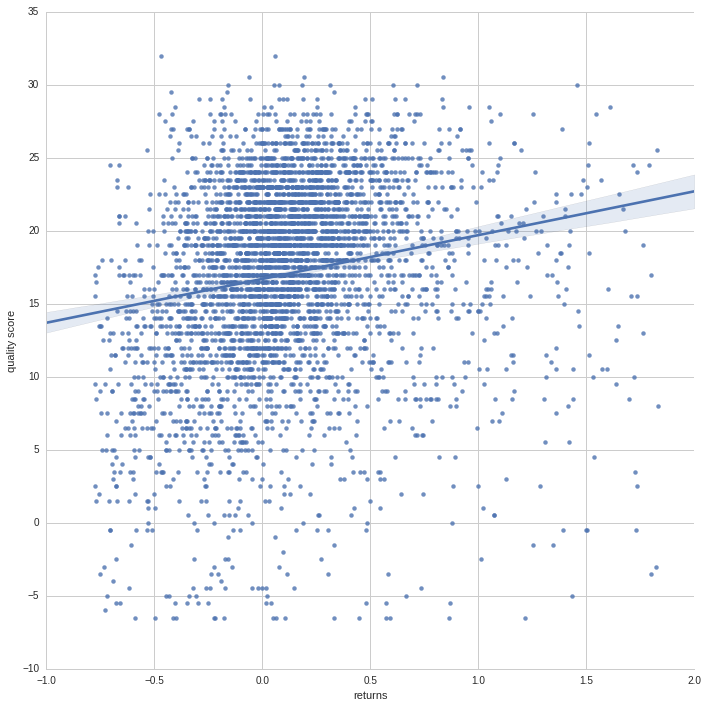

In [62]:
qualitylinereg = sns.lmplot(x='returns', y='quality score', data=result, size=10)

In [63]:
# WE CAN VISUALLY SEE THE CORRELATION BETWEEN RETURNS AND QUALITY ARE POSITIVELY CORRELATED!

In [64]:
X = result[['quality score']]
Y = result['returns']

In [65]:
X1 = sm.add_constant(X)
reg = sm.OLS(Y, X1).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                returns   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     153.1
Date:                Mon, 01 Apr 2019   Prob (F-statistic):           1.40e-34
Time:                        00:40:49   Log-Likelihood:                -2138.0
No. Observations:                4367   AIC:                             4280.
Df Residuals:                    4365   BIC:                             4293.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const            -0.0666      0.017     -3.988      0.000        -0.099    -0.034
quality score     0.0113      0.001     12.372      0.000         0.010     0.013
==============================================================================
Omnibus:                      871.426   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2030.836
Skew:                           1.120   Prob(JB):                         0.00
Kurtosis:                       5.479   Cond. No.                         51.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# HOWEVER WHEN WE RUN A REGRESSION ON THE DATA WE CAN SEE THE THE CORRELATION IS MINIMAL.
# WE HAVE MORE WORK TO DO!!!